In [71]:
"""

1. Multiple linear regression. 

"""

# Import libraries
import glob
import os
import numpy as np
import xarray as xr
import netCDF4
import pandas as pd
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import explained_variance_score, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

# Define base path
path = '/Users/jryan4/Dropbox (University of Oregon)/research/snowfall/'

In [4]:
# Read data
index_data = xr.open_dataset(path + 'data/masks/index_main.nc')

# Define maximum snowline
snowline_file = netCDF4.Dataset(path + 'data/masks/monthly_bare_ice_2012.nc')
snowline = snowline_file.variables['bare_ice'][1, :, :].filled(np.nan)
max_snowline = (snowline > 0.1)

# Define indices
index = list(zip(index_data['index_x'].values, index_data['index_y'].values))

# Define MERRA and exposure files
merra_snow_files = sorted(glob.glob(path + 'data/merra/*.nc'))
merra_temp_files = sorted(glob.glob(path + 'data/merra_t2m/*.nc'))
expo_files = sorted(glob.glob(path + 'data/firn-ice-exposure-dates/*.nc'))

# Define regions
regions = np.arange(1, 9)

# Define number of files
number = 18

In [5]:
# Define optimal date range
t_start = 170
s_start = 151

mean_exposure = []
mean_snowfall = []
mean_temp = []
for i in range(number):
    snow = xr.open_dataset(merra_snow_files[i])
    temp = xr.open_dataset(merra_temp_files[i])
    expo = xr.open_dataset(expo_files[i])
    
    # Mask ablation zone
    abl_expo = expo['first_55'].values[max_snowline].astype(float)
    abl_expo[abl_expo == 0] = np.nan
    abl_expo[abl_expo < 151] = np.nan
    
    region_exposure = []
    region_snowfall = []
    region_temp = []
    for region in regions:
        region_mask = index_data['region'].values == region
        region_snowfall.append(np.nanmean(np.mean(snow['snowfall'][s_start:183, :], axis=0)[region_mask]) * 86400 * 365 / 1000)
        region_temp.append(np.nanmean(np.mean(temp['t2m'][t_start:183, :], axis=0)[region_mask]))
        region_exposure.append(np.nanmedian(abl_expo[region_mask]))
    
    mean_exposure.append(region_exposure)
    mean_snowfall.append(region_snowfall)
    mean_temp.append(region_temp)

In [6]:
df_snowfall = pd.DataFrame(mean_snowfall, columns=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
df_temp = pd.DataFrame(mean_temp, columns=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
df_exposure= pd.DataFrame(mean_exposure, columns=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

df_temp['year'] = np.arange(2000, 2018)
df_snowfall['year'] = np.arange(2000, 2018)
df_exposure['year'] = np.arange(2000, 2018)

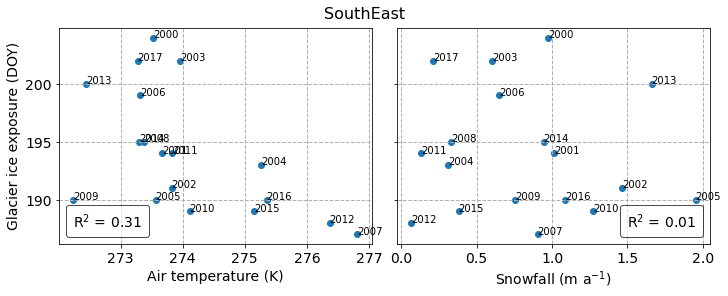

In [86]:
reg = 'SE'
reg_name = 'SouthEast'

s1, i1, r1, p1, e1 = stats.linregress(df_temp[reg],df_exposure[reg])
s2, i2, r2, p2, e2 = stats.linregress(df_snowfall[reg],df_exposure[reg])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True, layout='constrained')
fig.suptitle(reg_name, fontsize=16)
ax1.scatter(df_temp[reg], df_exposure[reg])
ax1.set_xlabel('Air temperature (K)', fontsize=14)
ax1.set_ylabel('Glacier ice exposure (DOY)', fontsize=14)

textstr = f'R$^2$ = {r1**2:.2f}'
text_box = AnchoredText(textstr, frameon=True, loc=3, pad=0.5, prop=dict(size=14))
text_box.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.setp(text_box.patch, facecolor='white', alpha=0.7)
ax1.add_artist(text_box)
for i, label in enumerate(list(df_temp['year'])):
    ax1.annotate(label, (df_temp[reg][i], df_exposure[reg][i]))

ax2.scatter(df_snowfall[reg], df_exposure[reg])
ax2.set_xlabel('Snowfall (m a$^{-1}$)', fontsize=14)

textstr = f'R$^2$ = {r2**2:.2f}'
text_box = AnchoredText(textstr, frameon=True, loc=4, pad=0.5, prop=dict(size=14))
text_box.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.setp(text_box.patch, facecolor='white', alpha=0.7)
ax2.add_artist(text_box)
for i, label in enumerate(list(df_temp['year'])):
    ax2.annotate(label, (df_snowfall[reg][i], df_exposure[reg][i]))

for ax in [ax1, ax2]:
    ax.grid(ls='dashed', lw=1)
    ax.tick_params(axis='both', which='major', labelsize=14)

In [87]:
# Perform multiple linear regression
df = pd.concat([df_snowfall[reg], df_temp[reg]], axis=1)
df.columns = ['snow','temp']

X = df[['snow', 'temp']]
y = df_exposure[reg]

model = linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

In [88]:
# Compute adjusted R2
yhat = model.predict(X)
r2= r2_score(y, yhat)
adj_r2 = 1 - (1 - r2) * (y.shape[0] - 1) / (y.shape[0] - df[['snow', 'temp']].shape[1] - 1)
adj_r2

0.2919120496897235

In [89]:
# Compare coefficients scaled by standard deviation
# https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
print(model.coef_ * X.std())

snow   -1.438607
temp   -3.384403
dtype: float64


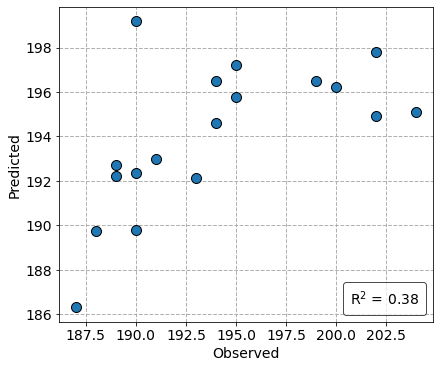

In [90]:
fig, ax1 = plt.subplots(figsize=(6, 5), layout='constrained')

ax1.scatter(y, yhat, s=100, edgecolor='k', zorder=2)
ax1.set_xlabel('Observed', fontsize=14)
ax1.set_ylabel('Predicted', fontsize=14)

textstr = f'R$^2$ = {r2_score(y, yhat):.2f}'
text_box = AnchoredText(textstr, frameon=True, loc=4, pad=0.5, prop=dict(size=14))
text_box.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.setp(text_box.patch, facecolor='white', alpha=0.7)
ax1.add_artist(text_box)

ax1.grid(ls='dashed', lw=1, zorder=1)
ax1.tick_params(axis='both', which='major', labelsize=14)

In [91]:
# Repeat using statsmodels
X = sm.add_constant(X)

In [92]:
results = sm.OLS(y, X).fit()
a = np.identity(len(results.params))
a = a[1:,:]
print(results.f_test(a))

<F test: F=4.504158517703159, p=0.029374573003752055, df_denom=15, df_num=2>


In [93]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     SE   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     4.504
Date:                Thu, 14 Jul 2022   Prob (F-statistic):             0.0294
Time:                        10:40:26   Log-Likelihood:                -50.933
No. Observations:                  18   AIC:                             107.9
Df Residuals:                      15   BIC:                             110.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        944.0433    252.092      3.745      0.0

/opt/anaconda3/envs/clouds/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
